####**Multimodal Transformers**
* PyTorchでMultimodal Transformersをファインチューニング(微調整)する方法を学ぶ。
* テキストと画像を処理できる変換器**Flava**と呼ばれる事前学習済みモデルを使用する。
* 例題として、画像とテキストのキャプションを含むミームで表現される感情を予測する。
---
* Learn how to fine-tune multimodal transformers in PyTorch.
* Use a pre-trained model called **Flava**, a transformer that can process text and images.
* As an example problem, we will predict sentiment expressed in memes containing image and text captions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/multimodal/

Mounted at /content/drive
/content/drive/MyDrive/multimodal


In [ ]:
! pip install accelerate -U
! pip install datasets transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/56.3 MB 151.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.2 MB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, pleas

In [ ]:
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, FlavaModel
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/multimodal/labels.csv")
dataset.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [ ]:
image_folder_path = '/content/drive/MyDrive/multimodal/images'
dataset['image_path'] = dataset['image_name'].apply(lambda x: os.path.join(image_folder_path, x)) #create a new column, image_path, which contains the complete path to the image file for each record in the dataset
dataset = dataset[dataset['text_corrected'].notna() & (dataset['text_corrected'] != '')] #filter out any rows that have missing or empty values in the text_corrected column
dataset = dataset.filter(["text_corrected", "image_path", "overall_sentiment"]) #filter the text_corrected, image_path, and overall_sentiment, columns and remove the remaining columns from the dataset

print("==============================================")
print(f'The shape of the dataset is: {dataset.shape}')
print("==============================================")
print(f'The number of sentiments in each category is:\n{dataset.overall_sentiment.value_counts()}')
print("==============================================")

dataset.head(10)

The shape of the dataset is: (100, 3)
The number of sentiments in each category is:
overall_sentiment
positive         48
neutral          22
very_positive    21
negative          6
very_negative     3
Name: count, dtype: int64


,text_corrected,image_path,overall_sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,/content/drive/MyDrive/multimodal/images/image...,very_positive
1,The best of #10 YearChallenge! Completed in le...,/content/drive/MyDrive/multimodal/images/image...,very_positive
2,Sam Thorne @Strippin ( Follow Follow Saw every...,/content/drive/MyDrive/multimodal/images/image...,positive
3,10 Year Challenge - Sweet Dee Edition,/content/drive/MyDrive/multimodal/images/image...,positive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,/content/drive/MyDrive/multimodal/images/image...,neutral
5,"1998: ""Don't get in car with strangers"" 2008: ...",/content/drive/MyDrive/multimodal/images/image...,negative
6,10 years challenge is lit af Üs & B erg 1945 1...,/content/drive/MyDrive/multimodal/images/image...,negative
7,10 Year Challenge emotional edition boredpanda...,/content/drive/MyDrive/multimodal/images/image...,neutral
8,Fornite died in 10 months but Minecraft never ...,/content/drive/MyDrive/multimodal/images/image...,positive
9,FACEBOOK '10 YEAR CHALLENGE': A PLOY OR A SIMP...,/content/drive/MyDrive/multimodal/images/image...,positive


CAPTAIN AMERICA CAPTAIN MARVEL COMIC BOOK THINGS CAPTAIN DEADPOOL CAPTAIN COLD Aye aye cap'n
positive


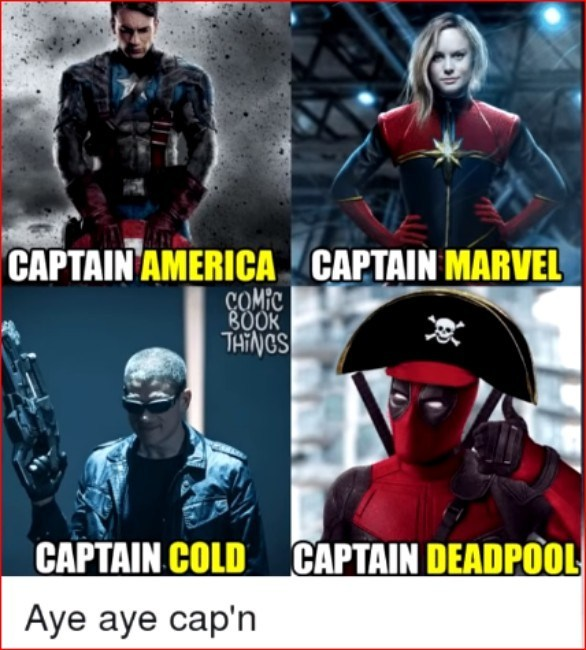

In [ ]:
index = 50 #50番目の要素/50th element

image_path = dataset["image_path"].iloc[index]
sample_image = Image.open(image_path)
sample_text = dataset["text_corrected"].iloc[index]
sentiment = dataset["overall_sentiment"].iloc[index]
print(sample_text)
print(sentiment)
sample_image

####センチメントラベルを数値に変換/Convert the sentiment labels into numeric values.

very_positive -> 2

positive -> 2

neutral -> 1

negative -> 0

very_negative -> 0

In [ ]:
dataset['overall_sentiment'] = dataset['overall_sentiment'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

print(f'The number of sentiments in each category is:\n{dataset.overall_sentiment.value_counts()}')
print("==============================================")
dataset.head()

The number of sentiments in each category is:
overall_sentiment
2    69
1    22
0     9
Name: count, dtype: int64


,text_corrected,image_path,overall_sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,/content/drive/MyDrive/multimodal/images/image...,2
1,The best of #10 YearChallenge! Completed in le...,/content/drive/MyDrive/multimodal/images/image...,2
2,Sam Thorne @Strippin ( Follow Follow Saw every...,/content/drive/MyDrive/multimodal/images/image...,2
3,10 Year Challenge - Sweet Dee Edition,/content/drive/MyDrive/multimodal/images/image...,2
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,/content/drive/MyDrive/multimodal/images/image...,1


* データセットを訓練セット、テストセット、検証セットにそれぞれ80、10、10の比率で分割
* split our dataset into train, test, and validation sets with a ratio of 80, 10, and 10, respectively

In [ ]:
dataset = dataset.sample(frac=1, random_state=42)

train_data, temp_data = train_test_split(dataset, test_size=0.2, random_state=42)

test_data, valid_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)
print("Validation set shape:", valid_data.shape)

Train set shape: (80, 3)
Test set shape: (10, 3)
Validation set shape: (10, 3)


* Hugging Faceから学習済みのmultimodal transformerをインポートする。
* テキスト情報と画像情報を結合・変換する変換プロセッサをインポートする。
---
* import a pre-trained multimodal transformer from Hugging Face.
* import a transformer processor that merges and converts the text and image information.

In [ ]:
flava_model = FlavaModel.from_pretrained("facebook/flava-full")
processor = AutoProcessor.from_pretrained("facebook/flava-full")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

* getitem()メソッドで、ミームのテキストと画像を、先ほどインポートしたFlavaプロセッサ・クラスのtext属性とimages属性に渡す。
* プロセッサは、input_ids、token_type_ids、attention_mask、pixel_valuesを返す。
* これらの値はFlavaモデルのインプットとして使用される。
---
* In the getitem_() method, we pass the meme text and image to the text and images attributes of the Flava processor class we imported earlier.
* The processor returns input_ids, token_type_ids, attention_mask, and pixel_values.
* These values are used as inputs to the Flava model.

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.max_length = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["text_corrected"]
        image_path = self.data.iloc[index]["image_path"]
        image = Image.open(image_path).convert("RGB")

        labels = self.data.iloc[index][['overall_sentiment']].values.astype(int)

        inputs = processor(text = text,
                   images= image,
                   return_tensors="pt",
                   padding=True
                   )

        input_ids = inputs['input_ids'][0]
        token_type_ids =  inputs['token_type_ids'][0]
        attention_mask = inputs['attention_mask'][0]
        pixel_values =  inputs['pixel_values'][0]

        input_ids = nn.functional.pad(input_ids, (0, self.max_length - input_ids.shape[0]), value=0)
        token_type_ids = nn.functional.pad(token_type_ids, (0, self.max_length - token_type_ids.shape[0]), value=0)
        attention_mask = nn.functional.pad(attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0)

        return input_ids, token_type_ids, attention_mask, pixel_values , torch.tensor(labels)

* MultimodalDatasetクラスを使用して、train_dataset、test_data、val_datasetデータフレームのPyTorchデータセットを作成します。
* モデルにデータのバッチを提供できるデータ・ローダー・オブジェクトを作成する。
---
* use the MultimodalDataset class to create the PyTorch datasets for train_dataset, test_data, and val_dataset dataframes.
* create data loader objects that can provide batches of data to model.

In [ ]:
train_dataset = MultimodalDataset(train_data)
test_dataset = MultimodalDataset(test_data)
val_dataset = MultimodalDataset(valid_data)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

####Creating and fine-tuning a multimodal classification model

In [ ]:
class MultimodalClassifier(nn.Module,):
    def __init__(self, num_labels, flava_model):
        super(MultimodalClassifier, self).__init__()
        self.model = flava_model
        self.classifier = nn.Sequential(

            nn.Linear(self.model.config.hidden_size, 1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, num_labels)

        )

    def forward(self, input_ids, token_type_ids, attention_mask, pixel_values):
        outputs = self.model(input_ids = input_ids,
                        token_type_ids = token_type_ids,
                        attention_mask = attention_mask,
                        pixel_values = pixel_values
                        )

        multimodal_embeddings = outputs.multimodal_embeddings
        x = multimodal_embeddings[:, -1, :]
        x = self.classifier(x)
        return x

* MultimodalClassifierクラスのオブジェクトを作成し、損失関数とオプティマイザを設定します。
* モデルを10エポック訓練し、各バッチの損失を表示する。
---
* create an object of the MultimodalClassifier class and set the loss function and the optimizer.
* train the model for ten epochs and display the loss for every batch.

In [ ]:
num_labels = train_data['overall_sentiment'].nunique()
model = MultimodalClassifier(num_labels, flava_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)

num_epochs = 10
n_total_steps = len(train_loader)

* 訓練データのバッチを取得し、それをマルチモーダル分類器に渡し、出力を取得し、損失を計算し、モデルの重みを更新するためにバックプロパゲーションを実行する。
* 出力は、最終エポックの最後の8バッチの学習損失を示す。
---
* fetch a batch of training data, pass it to our multimodal classifier, get the outputs, calculate the loss, and perform backpropagation to update the model weights.
* The output shows the training losses for the last eight batches of the final epoch.

In [ ]:
for epoch in range(num_epochs):

  for i, batch in enumerate (train_loader):

    input_ids, token_type_ids , attention_mask, pixel_values, labels = batch
    input_ids = input_ids.to(device)
    token_type_ids  = token_type_ids.to(device)
    attention_mask = attention_mask.to(device)
    pixel_values = pixel_values.to(device)

    labels = labels.view(-1)
    labels = labels.to(device)

    optimizer.zero_grad()

    logits = model(input_ids = input_ids,
                   token_type_ids = token_type_ids,
                   attention_mask = attention_mask,
                   pixel_values = pixel_values
    )

    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()


    if (i+1) % 16 == 0:
        print(f'epoch {epoch + 1}/ {num_epochs}, batch {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

* テストでのモデルの性能を評価する。
* evaluate the model performance on the test.

In [ ]:
all_labels = []
all_preds = []

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for i, batch in enumerate (test_loader):

    input_ids, token_type_ids , attention_mask, pixel_values, labels = batch
    input_ids = input_ids.to(device)
    token_type_ids  = token_type_ids.to(device)
    attention_mask = attention_mask.to(device)
    pixel_values = pixel_values.to(device)

    labels = labels.view(-1)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(input_ids = input_ids,
                   token_type_ids = token_type_ids,
                   attention_mask = attention_mask,
                   pixel_values = pixel_values
    )

    _, predictions = torch.max(outputs, 1)

    all_labels.append(labels.cpu().numpy())
    all_preds.append(predictions.cpu().numpy())

all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.70      1.00      0.82         7

    accuracy                           0.70        10
   macro avg       0.23      0.33      0.27        10
weighted avg       0.49      0.70      0.58        10

0.7


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* 出力結果は、全体として70％の精度を達成したことを示している。
* The output shows that we achieved an overall accuracy of 70%.